In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.VRPtest import *
from Problem.utils import *
import geoplot as gplt
import geopandas as gpd
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

# 25_2, 25_4, 25_8, 50_1, 50_2, 50_4, 75_1, 75_3, 75_6
dataset = "UK75_6"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}



In [3]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext,heterogeneousFleet=True)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)



cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}


min_allowed_drivetime_hours = 0


data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

problem = VRP(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[],'distance_to_origin':[]}


amount_of_runs = 30
amount_of_evaluations = 10000
observer_update_interval = 60
logpath = "parameter_data/reruns/{}".format(dataset)
try: 
    os.mkdir(logpath) 
except OSError as error: 
    print(error) 
mutation_arange = np.arange(0.1,1,0.2)
crossover_arange = np.arange(0.25,0.8,0.25)
population_size_arange = np.arange(10,40,10)


genetic_algorithms_parameters = []

for x in mutation_arange:
    for y in crossover_arange:
        for z in population_size_arange:
            genetic_algorithms_parameters.append({"mutation":np.round(x,2),"crossover":np.round(y,2),"population_size":np.round(z,2)})

            
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}
            


[Errno 17] File exists: 'parameter_data/reruns/UK75_6'


In [4]:
def plot_vehicle_drivetimes(dataframe,parameter_group):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles$" % (vehicle_amount))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicles")
    
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

# Simulated Annealing

In [6]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime

parameters_SA = optimal_parameters["SA"]

plot_data_SA = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_SA = VRP(data_model_input_single_objective)
    problem_SA.name = "SA"
    problem_SA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                   mutation=PermutationSwapMutation(parameters_SA["mutation"]),
                                   termination_criterion=StoppingByEvaluations(max_evaluations))

    performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_SA])
    performance_observer_SA.maxEpochs=  amount_of_runs
    performance_observer_SA.currentEpoch = x

    algorithm_SA.observable.register(observer=performance_observer_SA)
    algorithm_SA.run() 

    solutions_SA = algorithm_SA.get_result()        
    store_plot_data(plot_data_SA,performance_observer_SA,solutions_SA)


sa_numerical_path = get_numerical_path(solutions_SA.path,vehicles)


Epoch:30 of 30
Evaluations: 9960/10000
Params: {'mutation': 0.9}
IGD:1918.126572896794
Best fitness: 461.1962                          
Best total fuel consumption:240.81 
Best total drive time:1902.95                          
Computing time: 5.75s
Average computing speed: 865.85it/s                          
Current Route:[['V0', 33, 30, 34, 19, 29, 2], ['V7', 47, 1], ['V2', 46, 14, 16, 2], ['V6', 48, 4], ['V4', 18, 39, 11, 42, 20], ['V3', 31, 8, 38, 27, 24, 2], ['V8', 36, 17, 44, 7, 45], ['V9', 25, 13, 50, 26, 37, 2], ['V10', 41, 45], ['V12', 49, 3, 12, 23, 9, 28, 20], ['V13', 22, 43, 20]]
Flags: []
Violation:0
Vehicle Amount:11


In [70]:
pd.DataFrame(plot_data_SA).to_csv("{}/SA.csv".format(logpath))

# Genetic Algorithm

In [7]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime


parameters_GA = optimal_parameters["GA"]



plot_data_GA = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_GA = VRP(data_model_input_single_objective)
    problem_GA.name = "GA"
    problem_GA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                    population_size=parameters_GA["population_size"],
                    offspring_population_size=parameters_GA["population_size"],
                    mutation=PermutationSwapMutation(parameters_GA["mutation"]),
                    crossover=PMXCrossover(parameters_GA["crossover"]),
                    selection=BestSolutionSelection(),
                    termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
                    ,population_evaluator=MultiprocessEvaluator()
                    )


    performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_GA])
    performance_observer_GA.maxEpochs= amount_of_runs
    performance_observer_GA.currentEpoch = x
    algorithm_GA.observable.register(observer=performance_observer_GA)
    
    start_time = datetime.now() 
    algorithm_GA.run()
    run_time = datetime.now() - start_time
    solutions_GA = algorithm_GA.get_result()


    store_plot_data(plot_data_GA,performance_observer_GA,solutions_GA)
    

Epoch:30 of 30
Evaluations: 10020/10000
Params: {'mutation': 0.9, 'crossover': 0.25, 'population_size': 30}
IGD:1888.0976164083024
Best fitness: 466.4098                          
Best total fuel consumption:238.29 
Best total drive time:1873.0                          
Computing time: 5.21s
Average computing speed: 955.19it/s                          
Current Route:[['V0', 42, 33, 30, 34, 19, 29, 2], ['V6', 47, 1], ['V3', 50, 44, 7, 45], ['V2', 48, 37, 2], ['V4', 18, 39, 20], ['V9', 36, 45], ['V7', 27, 24, 38, 16, 46, 31, 2], ['V5', 11, 20], ['V8', 17, 25, 13, 14, 26, 8, 2], ['V10', 41, 45], ['V12', 49, 3, 12, 23, 9, 28, 20], ['V13', 22, 43, 20]]
Flags: []
Violation:0
Vehicle Amount:12


In [72]:
pd.DataFrame(plot_data_GA).to_csv("{}/GA.csv".format(logpath))

# NSGA-II

In [5]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_NSGAII = optimal_parameters["NSGAII"]

plot_data_NSGAII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_NSGAII = VRP(data_model_input_multi_objective)
    problem_NSGAII.name = "NSGA-II"
    problem_NSGAII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                            population_size=parameters_NSGAII["population_size"],
                            offspring_population_size=parameters_NSGAII["population_size"],
                            mutation=PermutationSwapMutation(parameters_NSGAII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator()

                               )

    performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAII])
    performance_observer_NSGAII.maxEpochs= amount_of_runs
    performance_observer_NSGAII.currentEpoch = x



    algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
    algorithm_NSGAII.run()

    solutions_NSGAII = algorithm_NSGAII.get_result()
    front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
    
    store_plot_data(plot_data_NSGAII,performance_observer_NSGAII,front_NSGAII[0])




Epoch:30 of 30
Evaluations: 4980/5000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 30} 
IGD:311.4552180515214
Best fitness: 219.4111 --- 221.05                        
Best total fuel consumption:219.41 
Computing time: 5.43s                        
Average computing speed: 916.6it/s
Current Route:[['V0', 42, 33, 30, 34, 19, 29, 2], ['V2', 37, 44, 7, 45], ['V3', 48, 31, 2], ['V5', 11, 18, 39, 20], ['V6', 47, 46, 8, 27, 24, 2], ['V8', 26, 50, 2], ['V9', 36, 17, 25, 13, 14, 16, 38, 2], ['V10', 41, 45], ['V12', 49, 3, 12, 23, 9, 28, 20], ['V13', 22, 43, 20]]
Flags: []                        
Violation:0
Vehicle amount:10


# NSGA-III

In [8]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameters_NSGAIII = optimal_parameters["NSGAIII"]


plot_data_NSGAIII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):

    problem_NSGAIII = VRP(data_model_input_multi_objective)
    problem_NSGAIII.name = "NSGA-III"
    problem_NSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                            population_size=parameters_NSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_NSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAIII])
    performance_observer_NSGAIII.maxEpochs=  amount_of_runs
    performance_observer_NSGAIII.currentEpoch =  x

    algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
    algorithm_NSGAIII.run()

    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)

    store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0])



nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)


Epoch:30 of 30
Evaluations: 4980/5000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 20} 
IGD:302.9105978658691
Best fitness: 218.4921 --- 209.8                        
Best total fuel consumption:218.49 
Computing time: 6.25s                        
Average computing speed: 797.03it/s
Current Route:[['V0', 42, 30, 33, 19, 34, 16, 2], ['V2', 26, 44, 7, 45], ['V3', 48, 4], ['V4', 11, 18, 39, 20], ['V6', 47, 46, 8, 31, 2], ['V8', 50, 37, 27, 24, 2], ['V9', 36, 17, 25, 13, 14, 29, 38, 2], ['V10', 41, 45], ['V12', 49, 3, 12, 23, 9, 28, 20], ['V13', 22, 43, 20]]
Flags: []                        
Violation:0
Vehicle amount:10


In [ ]:
get_solution_results(front_NSGAIII[0],routingContext,vehicles)

# UNSGA-III

In [9]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameters_UNSGAIII = optimal_parameters["UNSGAIII"]

plot_data_UNSGAIII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):

    problem_UNSGAIII = VRP(data_model_input_multi_objective)
    problem_UNSGAIII.name = "NSGA-III"
    problem_UNSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_UNSGAIII = UNSGAIII(problem=problem_UNSGAIII,
                            population_size=parameters_UNSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_UNSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_UNSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_UNSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_UNSGAIII])
    performance_observer_UNSGAIII.maxEpochs= amount_of_runs
    performance_observer_UNSGAIII.currentEpoch =  x

    algorithm_UNSGAIII.observable.register(observer=performance_observer_UNSGAIII)
    algorithm_UNSGAIII.run()

    solutions_UNSGAIII = algorithm_UNSGAIII.get_result()
    front_UNSGAIII = get_non_dominated_solutions(solutions_UNSGAIII)

    store_plot_data(plot_data_UNSGAIII,performance_observer_UNSGAIII,front_UNSGAIII[0])

     
Unsga3_numerical_path = get_numerical_path(front_UNSGAIII[0].path,vehicles)

Epoch:30 of 30
Evaluations: 4980/5000
Params: {'mutation': 0.9, 'crossover': 0.25, 'population_size': 20} 
IGD:319.45855511250954
Best fitness: 236.584 --- 214.6667                        
Best total fuel consumption:236.58 
Computing time: 6.42s                        
Average computing speed: 775.35it/s
Current Route:[['V0', 42, 33, 30, 19, 34, 29, 2], ['V10', 36, 45], ['V3', 31, 7, 37, 2], ['V6', 48, 4], ['V4', 11, 18, 39, 20], ['V2', 46, 8, 38, 50, 26, 27, 2], ['V7', 47, 1], ['V9', 17, 25, 13, 14, 16, 24, 2], ['V8', 44, 41, 45], ['V12', 49, 3, 12, 23, 9, 28, 20], ['V13', 22, 43, 20]]
Flags: []                        
Violation:0
Vehicle amount:11


In [ ]:
get_solution_results(front_UNSGAIII[0],routingContext,vehicles)

# IBEA

In [10]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_IBEA = optimal_parameters["IBEA"]

plot_data_IBEA = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_IBEA = VRP(data_model_input_multi_objective)
    problem_IBEA.name = "IBEA"
    problem_IBEA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_IBEA = IBEA(problem=problem_IBEA,
                            population_size=parameters_IBEA["population_size"],
                            offspring_population_size=parameters_IBEA["population_size"],
                            kappa =1,
                            mutation=PermutationSwapMutation(parameters_IBEA["mutation"]),
                            crossover=PMXCrossover(parameters_IBEA["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator(),
                               )

    performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_IBEA])
    performance_observer_IBEA.maxEpochs= amount_of_runs
    performance_observer_IBEA.currentEpoch =  x


    algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
    algorithm_IBEA.run()

    solutions_IBEA = algorithm_IBEA.get_result()
    front_IBEA = get_non_dominated_solutions(solutions_IBEA)
    store_plot_data(plot_data_IBEA,performance_observer_IBEA,front_IBEA[0])

ibea_numerical_path = get_numerical_path(front_IBEA[0].path,vehicles)

Epoch:30 of 30
Evaluations: 4980/5000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 20} 
IGD:311.640430946724
Best fitness: 218.392 --- 222.3167                        
Best total fuel consumption:218.39 
Computing time: 7.52s                        
Average computing speed: 662.06it/s
Current Route:[['V0', 42, 30, 33, 19, 34, 29, 2], ['V2', 46, 44, 7, 45], ['V6', 48, 4], ['V4', 11, 18, 39, 20], ['V3', 31, 8, 37, 26, 50, 38, 24, 2], ['V7', 47, 1], ['V9', 36, 17, 25, 13, 14, 16, 27, 2], ['V10', 41, 45], ['V12', 49, 3, 12, 23, 9, 28, 20], ['V13', 22, 43, 20]]
Flags: []                        
Violation:0
Vehicle amount:10


(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

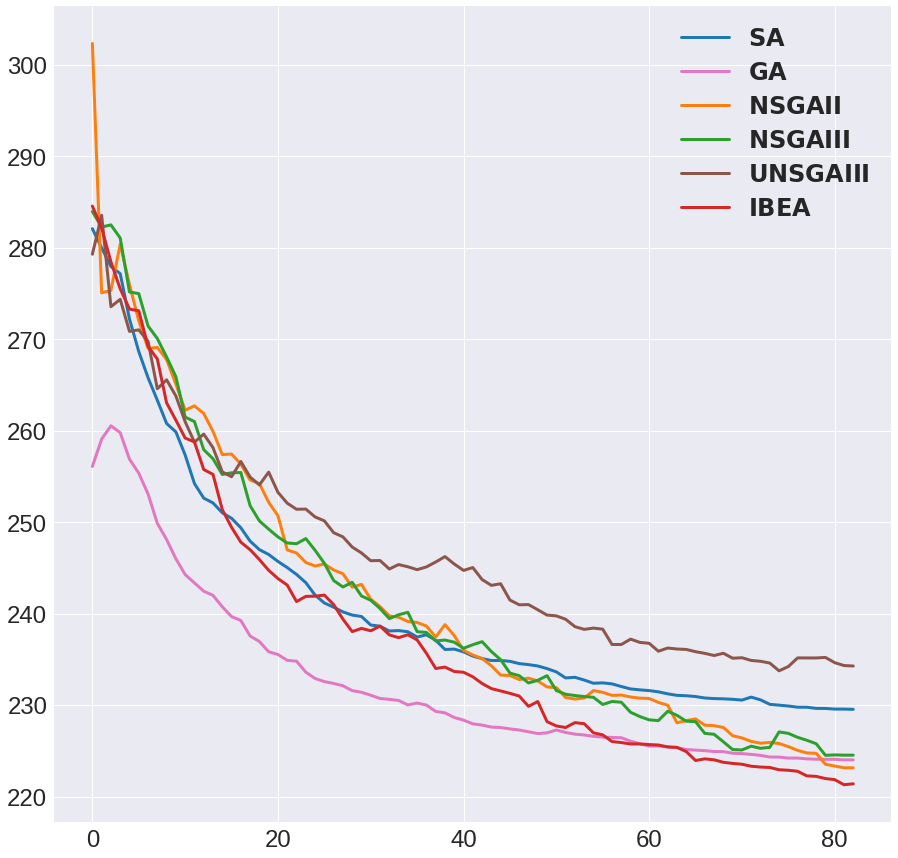

In [11]:
sa_curve = np.mean(plot_data_SA["fuel_consumption"],axis=0)
ga_curve = np.mean(plot_data_GA["fuel_consumption"],axis=0)
nsga2_curve = np.mean(plot_data_NSGAII["fuel_consumption"],axis=0)
nsga3_curve = np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["fuel_consumption"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["fuel_consumption"],axis=0)
curves = np.array([sa_curve,ga_curve,nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve])
lables =["SA","GA","NSGAII","NSGAIII","UNSGAIII","IBEA"]




plot_conv_curves(curves,lables,show_domination_and_percentage_interval=False)

(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

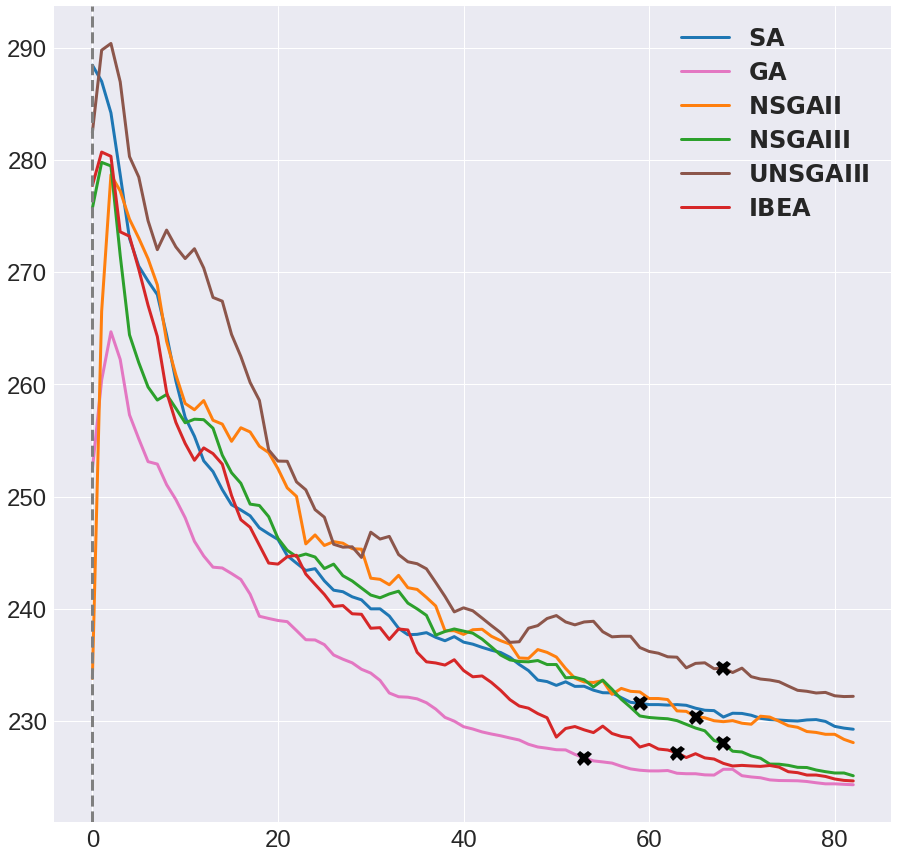

In [24]:
sa_curve = np.mean(plot_data_SA["fuel_consumption"],axis=0)
ga_curve = np.mean(plot_data_GA["fuel_consumption"],axis=0)
nsga2_curve = np.mean(plot_data_NSGAII["fuel_consumption"],axis=0)
nsga3_curve = np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["fuel_consumption"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["fuel_consumption"],axis=0)
curves = np.array([sa_curve,ga_curve,nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve])
lables =["SA","GA","NSGAII","NSGAIII","UNSGAIII","IBEA"]




plot_conv_curves(curves,lables)

(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

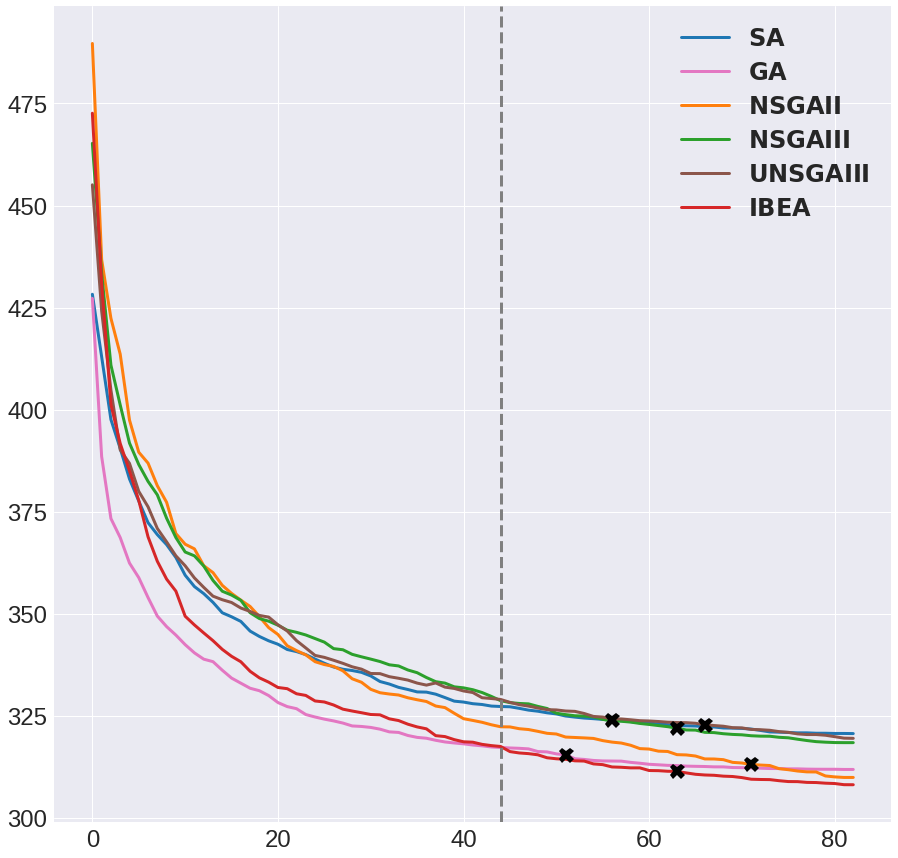

In [12]:
sa_curve = np.mean(plot_data_SA["distance_to_origin"],axis=0)
ga_curve = np.mean(plot_data_GA["distance_to_origin"],axis=0)
nsga2_curve = np.mean(plot_data_NSGAII["distance_to_origin"],axis=0)
nsga3_curve = np.mean(plot_data_NSGAIII["distance_to_origin"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["distance_to_origin"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["distance_to_origin"],axis=0)
curves = np.array([sa_curve,ga_curve,nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve])
lables =["SA","GA","NSGAII","NSGAIII","UNSGAIII","IBEA"]




plot_conv_curves(curves,lables)

(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

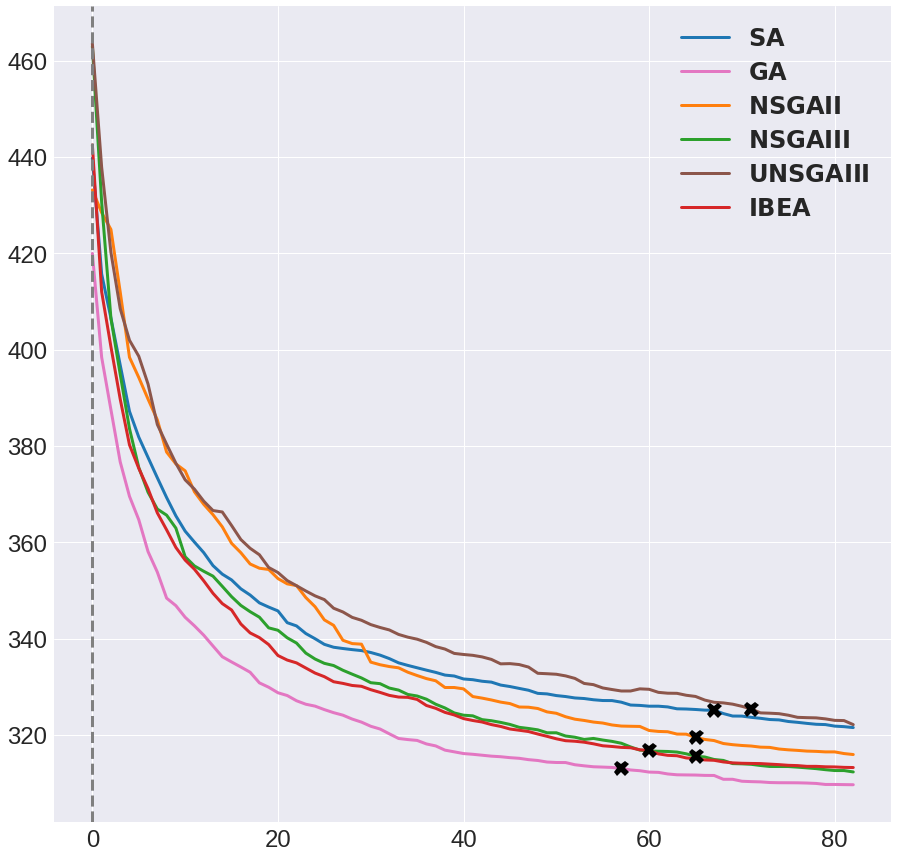

In [25]:
sa_curve = np.mean(plot_data_SA["distance_to_origin"],axis=0)
ga_curve = np.mean(plot_data_GA["distance_to_origin"],axis=0)
nsga2_curve = np.mean(plot_data_NSGAII["distance_to_origin"],axis=0)
nsga3_curve = np.mean(plot_data_NSGAIII["distance_to_origin"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["distance_to_origin"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["distance_to_origin"],axis=0)
curves = np.array([sa_curve,ga_curve,nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve])
lables =["SA","GA","NSGAII","NSGAIII","UNSGAIII","IBEA"]




plot_conv_curves(curves,lables)

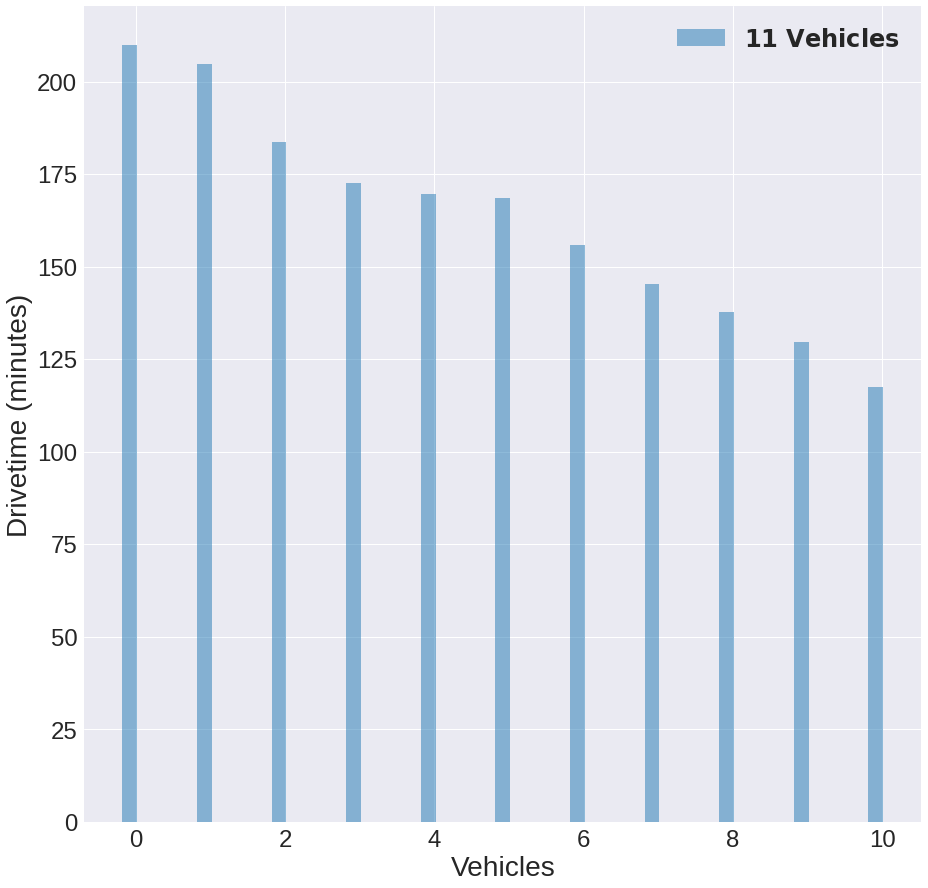

In [13]:
ga_df = pd.DataFrame(plot_data_GA)
ga_df["final_distance_to_origin"] =  [x[1]["distance_to_origin"][-1]for x in ga_df.iterrows()]
routes = ga_df.sort_values(by = "final_distance_to_origin").head(1).paths.to_list()[0]
ga_df["Parameter Group"] = 1
ga_best = ga_df.head(1)
plot_vehicle_drivetimes(ga_best,1)

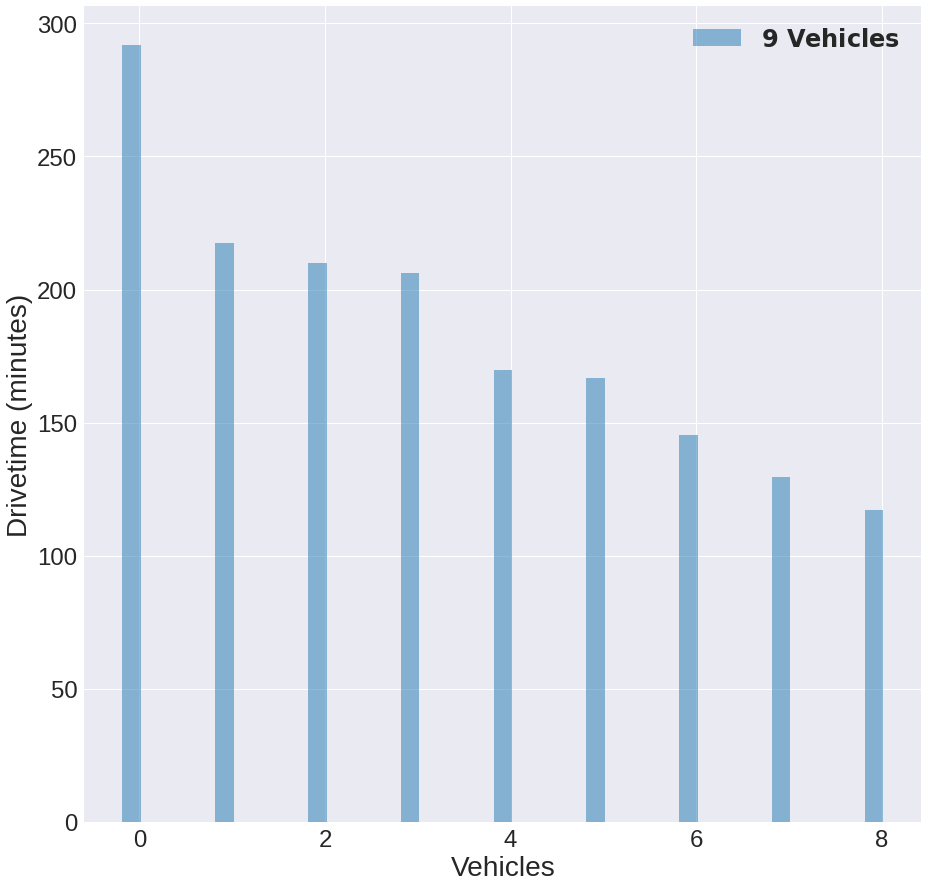

In [14]:
ibea_df = pd.DataFrame(plot_data_IBEA)
ibea_df["final_distance_to_origin"] =  [x[1]["distance_to_origin"][-1]for x in ibea_df.iterrows()]
routes = ibea_df.sort_values(by = "final_distance_to_origin").head(1).paths.to_list()[0]
ibea_df["Parameter Group"] = 1
ibea_best = ibea_df.head(1)
plot_vehicle_drivetimes(ibea_best,1)

In [49]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=np.mean(points_coordinate,axis=0), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = get_numerical_path(ga_best.paths[0],vehicles)
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (points_coordinate[stop][0],points_coordinate[stop][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00'),popup=customer_demands[stop]).add_to(folium_map)
      
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


In [51]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=np.mean(points_coordinate,axis=0), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = get_numerical_path(ibea_best.paths[0],vehicles)
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (points_coordinate[stop][0],points_coordinate[stop][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00'),popup=customer_demands[stop]).add_to(folium_map)
      
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map
